In [1]:
from __future__ import division
import time

import copy
import itertools
import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from itertools import permutations
from dgl.data import SBMMixture
from torch.utils.data import DataLoader

Using backend: pytorch


In [2]:
class GNNModule(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super().__init__()
        self.out_feats = out_feats
        self.radius = radius

        new_linear = lambda: nn.Linear(in_feats, out_feats)
        new_linear_list = lambda: nn.ModuleList([new_linear() for i in range(radius)])

        self.theta_x, self.theta_deg, self.theta_y = \
            new_linear(), new_linear(), new_linear()
        self.theta_list = new_linear_list()

        self.gamma_y, self.gamma_deg, self.gamma_x = \
            new_linear(), new_linear(), new_linear()
        self.gamma_list = new_linear_list()

        self.bn_x = nn.BatchNorm1d(out_feats)
        self.bn_y = nn.BatchNorm1d(out_feats)

    def aggregate(self, g, z):
        z_list = []
        g.set_n_repr({'z' : z})
        g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
        z_list.append(g.get_n_repr()['z'])
        for i in range(self.radius - 1):
            for j in range(2 ** i):
                g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
            z_list.append(g.get_n_repr()['z'])
        return z_list

    def forward(self, g, lg, x, y, deg_g, deg_lg, pm_pd):
        pmpd_x = F.embedding(pm_pd, x)

        sum_x = sum(theta(z) for theta, z in zip(self.theta_list, self.aggregate(g, x)))

        g.set_e_repr({'y' : y})
        g.update_all(fn.copy_edge(edge='y', out='m'), fn.sum('m', 'pmpd_y'))
        pmpd_y = g.pop_n_repr('pmpd_y')

        x = self.theta_x(x) + self.theta_deg(deg_g * x) + sum_x + self.theta_y(pmpd_y)
        n = self.out_feats // 2
        x = th.cat([x[:, :n], F.relu(x[:, n:])], 1)
        x = self.bn_x(x)

        sum_y = sum(gamma(z) for gamma, z in zip(self.gamma_list, self.aggregate(lg, y)))

        y = self.gamma_y(y) + self.gamma_deg(deg_lg * y) + sum_y + self.gamma_x(pmpd_x)
        y = th.cat([y[:, :n], F.relu(y[:, n:])], 1)
        y = self.bn_y(y)

        return x, y

In [3]:
class GNN(nn.Module):
    def __init__(self, feats, radius, n_classes):
        super(GNN, self).__init__()
        self.linear = nn.Linear(feats[-1], n_classes)
        self.module_list = nn.ModuleList([GNNModule(m, n, radius)
                                          for m, n in zip(feats[:-1], feats[1:])])

    def forward(self, g, lg, deg_g, deg_lg, pm_pd):
        x, y = deg_g, deg_lg
        for module in self.module_list:
            x, y = module(g, lg, x, y, deg_g, deg_lg, pm_pd)
        return self.linear(x)

In [4]:
def compute_overlap(z_list):
    ybar_list = [th.max(z, 1)[1] for z in z_list]
    overlap_list = []
    for y_bar in ybar_list:
        accuracy = max(th.sum(y_bar == y).item() for y in y_list) / NUMBER_OF_NODES
        overlap = (accuracy - 1 / NUMBER_OF_COMMUNITIES) / (1 - 1 / NUMBER_OF_COMMUNITIES)
        overlap_list.append(overlap)
    return sum(overlap_list) / len(overlap_list)

def from_np(f, *args):
    def wrap(*args):
        new = [th.from_numpy(x) if isinstance(x, np.ndarray) else x for x in args]
        return f(*new)
    return wrap

@from_np
def step(i, j, g, lg, deg_g, deg_lg, pm_pd):
    deg_g = deg_g.to(device)
    deg_lg = deg_lg.to(device)
    pm_pd = pm_pd.to(device)
    t0 = time.time()
    z = model(g, lg, deg_g, deg_lg, pm_pd)
    t_forward = time.time() - t0

    z_list = th.chunk(z, BATCH_SIZE, 0)
    loss = sum(min(F.cross_entropy(z, y) for y in y_list) for z in z_list) / BATCH_SIZE
    overlap = compute_overlap(z_list)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    t_backward = time.time() - t0
    optimizer.step()

    return loss, overlap, t_forward, t_backward

@from_np
def inference(g, lg, deg_g, deg_lg, pm_pd):
    deg_g = deg_g.to(device)
    deg_lg = deg_lg.to(device)
    pm_pd = pm_pd.to(device)

    z = model(g, lg, deg_g, deg_lg, pm_pd)

    return z

def test():
    p_list =[6, 5.5, 5, 4.5, 1.5, 1, 0.5, 0]
    q_list =[0, 0.5, 1, 1.5, 4.5, 5, 5.5, 6]
    N = 1
    overlap_list = []
    for p, q in zip(p_list, q_list):
        dataset = SBMMixture(N, NUMBER_OF_NODES, NUMBER_OF_COMMUNITIES, pq=[[p, q]] * N)
        loader = DataLoader(dataset, N, collate_fn=dataset.collate_fn)
        g, lg, deg_g, deg_lg, pm_pd = next(iter(loader))
        z = inference(g, lg, deg_g, deg_lg, pm_pd)
        overlap_list.append(compute_overlap(th.chunk(z, N, 0)))
    return overlap_list

In [5]:
def visualize(labels, g, ax=None):
    pos = nx.spring_layout(g, seed=1)
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False, ax=ax)

# Graph generation and model definition

In [6]:
GPU_INDEX = -1

VERBOSE = False

NUMBER_OF_COMMUNITIES = 2
NUMBER_OF_GRAPHS = 10
NUMBER_OF_NODES = 100
NUMBER_OF_LAYERS = 30
NUMBER_OF_FEATURES = 16
NUMBER_OF_EPOCHS = 75
OPTIMIZER = 'Adam'
BATCH_SIZE = 1
RADIUS = 3
LEARNING_RATE = 0.001

device = th.device('cpu') if GPU_INDEX < 0 else th.device('cuda:%d' % GPU_INDEX)

training_dataset = SBMMixture(NUMBER_OF_GRAPHS, NUMBER_OF_NODES, NUMBER_OF_COMMUNITIES)
training_loader = DataLoader(training_dataset, BATCH_SIZE,
                             collate_fn=training_dataset.collate_fn, drop_last=True)

ones = th.ones(NUMBER_OF_NODES // NUMBER_OF_COMMUNITIES)
y_list = [th.cat([x * ones for x in p]).long().to(device) for p in permutations(range(NUMBER_OF_COMMUNITIES))]

feats = [1] + [NUMBER_OF_FEATURES] * NUMBER_OF_LAYERS + [NUMBER_OF_COMMUNITIES]
model = GNN(feats, RADIUS, NUMBER_OF_COMMUNITIES).to(device)
optimizer = getattr(optim, OPTIMIZER)(model.parameters(), lr=LEARNING_RATE)

# Training graph visualization

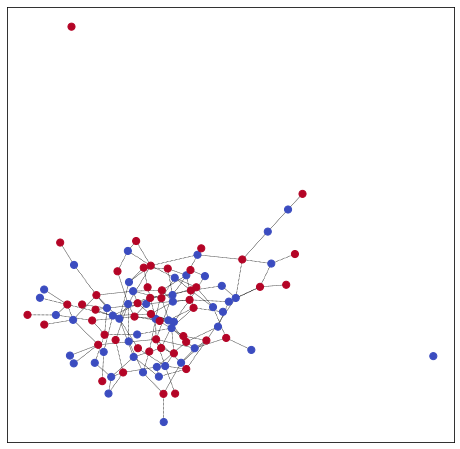

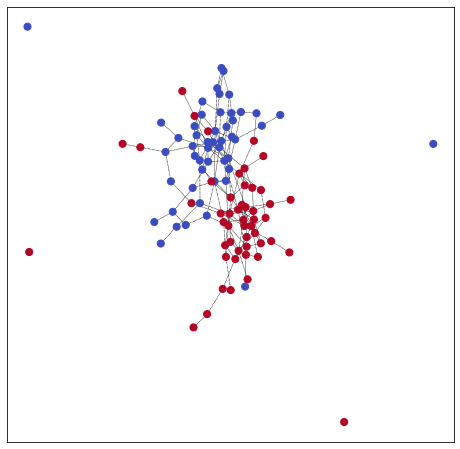

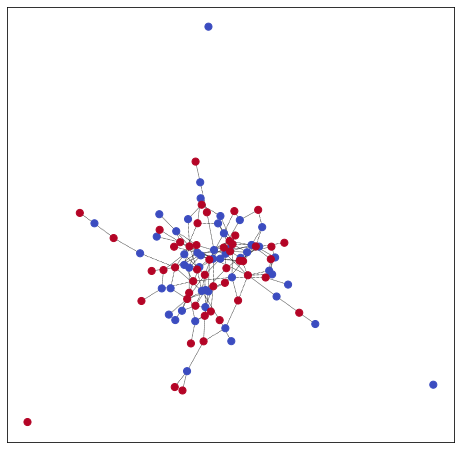

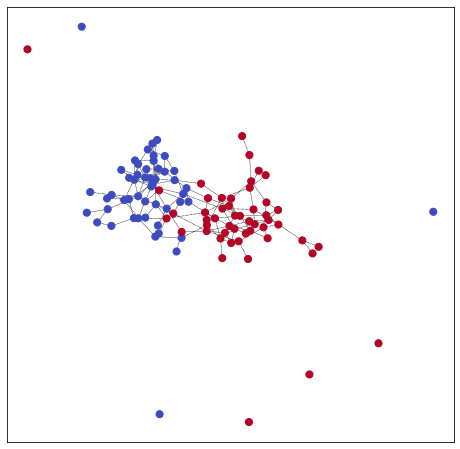

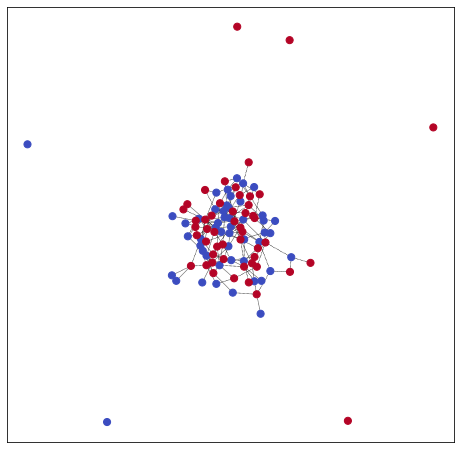

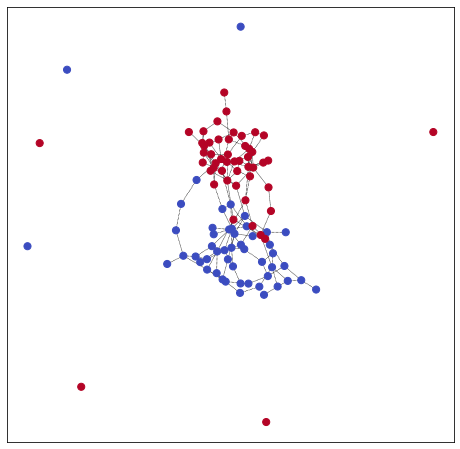

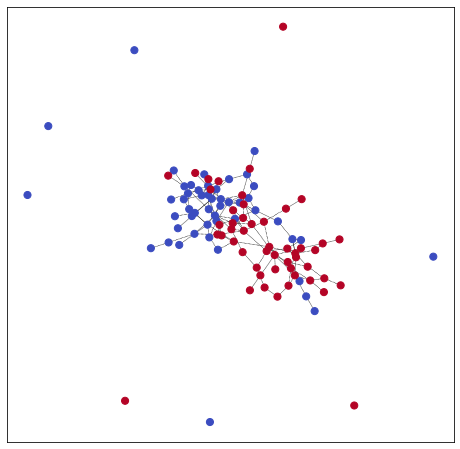

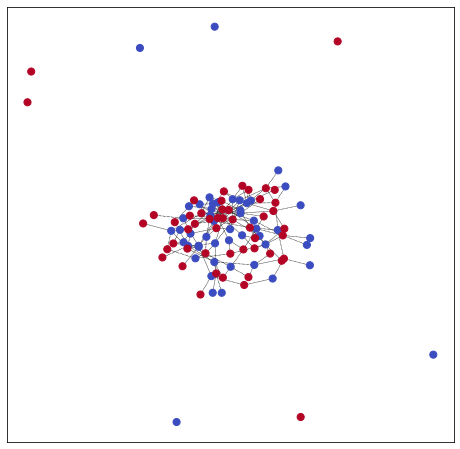

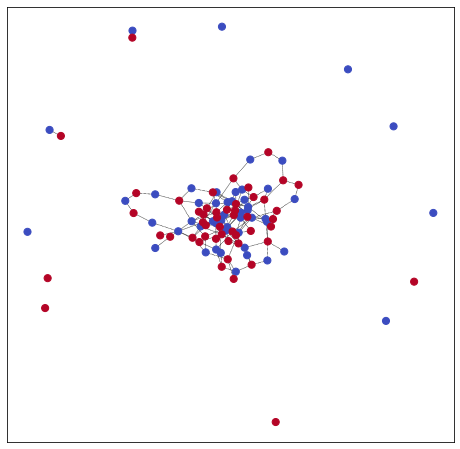

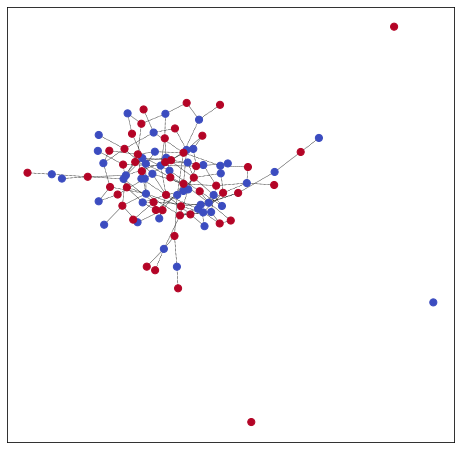

In [7]:
for graph in training_dataset:
    plt.figure(figsize=(8, 8))
    visualize(y_list[0].tolist(), graph[0].to_networkx())

# Training

In [8]:
n_iterations = NUMBER_OF_GRAPHS // BATCH_SIZE

for i in range(NUMBER_OF_EPOCHS):
    total_loss, total_overlap, s_forward, s_backward = 0, 0, 0, 0
    for j, [g, lg, deg_g, deg_lg, pm_pd] in enumerate(training_loader):
        loss, overlap, t_forward, t_backward = step(i, j, g, lg, deg_g, deg_lg, pm_pd)

        total_loss += loss
        total_overlap += overlap
        s_forward += t_forward
        s_backward += t_backward

        epoch = '0' * (len(str(NUMBER_OF_EPOCHS)) - len(str(i)))
        iteration = '0' * (len(str(n_iterations)) - len(str(j)))
        if VERBOSE:
            print('[epoch %s%d iteration %s%d] loss %.3f | overlap %.3f'
                  % (epoch, i, iteration, j, loss, overlap))

    epoch = '0' * (len(str(NUMBER_OF_EPOCHS)) - len(str(i)))
    loss = total_loss / (j + 1)
    overlap = total_overlap / (j + 1)
    t_forward = s_forward / (j + 1)
    t_backward = s_backward / (j + 1)
    print('[epoch %s%d] loss %.3f | overlap %.3f | forward time %.3fs | backward time %.3fs'
          % (epoch, i, loss, overlap, t_forward, t_backward))

    overlap_list = test()
    overlap_str = ' - '.join(['%.3f' % overlap for overlap in overlap_list])
    print('[epoch %s%d] overlap: %s' % (epoch, i, overlap_str))

[epoch 00] loss 0.617 | overlap 0.174 | forward time 0.291s | backward time 0.203s
[epoch 00] overlap: 0.340 - 0.260 - 0.020 - 0.120 - 0.020 - 0.080 - 0.000 - 0.100
[epoch 01] loss 0.662 | overlap 0.132 | forward time 0.232s | backward time 0.188s
[epoch 01] overlap: 0.360 - 0.240 - 0.160 - 0.140 - 0.000 - 0.000 - 0.160 - 0.020
[epoch 02] loss 0.635 | overlap 0.194 | forward time 0.205s | backward time 0.142s
[epoch 02] overlap: 0.080 - 0.260 - 0.000 - 0.120 - 0.060 - 0.320 - 0.200 - 0.580
[epoch 03] loss 0.598 | overlap 0.268 | forward time 0.212s | backward time 0.158s
[epoch 03] overlap: 0.280 - 0.260 - 0.040 - 0.140 - 0.100 - 0.120 - 0.420 - 0.580
[epoch 04] loss 0.614 | overlap 0.302 | forward time 0.167s | backward time 0.109s
[epoch 04] overlap: 0.560 - 0.420 - 0.320 - 0.060 - 0.220 - 0.200 - 0.460 - 0.420
[epoch 05] loss 0.572 | overlap 0.396 | forward time 0.166s | backward time 0.115s
[epoch 05] overlap: 0.620 - 0.520 - 0.160 - 0.360 - 0.080 - 0.540 - 0.280 - 0.620
[epoch 06]

[epoch 50] loss 0.441 | overlap 0.626 | forward time 0.175s | backward time 0.116s
[epoch 50] overlap: 0.560 - 0.120 - 0.180 - 0.100 - 0.040 - 0.060 - 0.720 - 0.880
[epoch 51] loss 0.429 | overlap 0.628 | forward time 0.170s | backward time 0.119s
[epoch 51] overlap: 0.900 - 0.860 - 0.460 - 0.340 - 0.360 - 0.420 - 0.740 - 0.900
[epoch 52] loss 0.431 | overlap 0.614 | forward time 0.169s | backward time 0.123s
[epoch 52] overlap: 0.780 - 0.800 - 0.400 - 0.100 - 0.180 - 0.340 - 0.880 - 0.940
[epoch 53] loss 0.418 | overlap 0.652 | forward time 0.176s | backward time 0.114s
[epoch 53] overlap: 0.880 - 0.780 - 0.240 - 0.140 - 0.180 - 0.520 - 0.800 - 0.860
[epoch 54] loss 0.418 | overlap 0.642 | forward time 0.168s | backward time 0.115s
[epoch 54] overlap: 0.860 - 0.740 - 0.140 - 0.020 - 0.080 - 0.240 - 0.560 - 0.920
[epoch 55] loss 0.418 | overlap 0.636 | forward time 0.166s | backward time 0.112s
[epoch 55] overlap: 1.000 - 0.780 - 0.060 - 0.380 - 0.100 - 0.000 - 0.660 - 0.800
[epoch 56]

# Prediction visualization

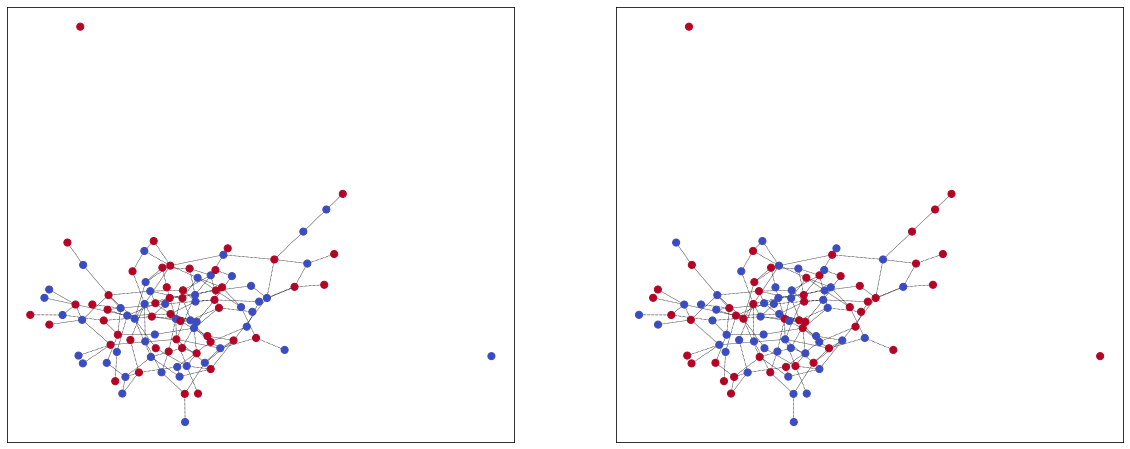

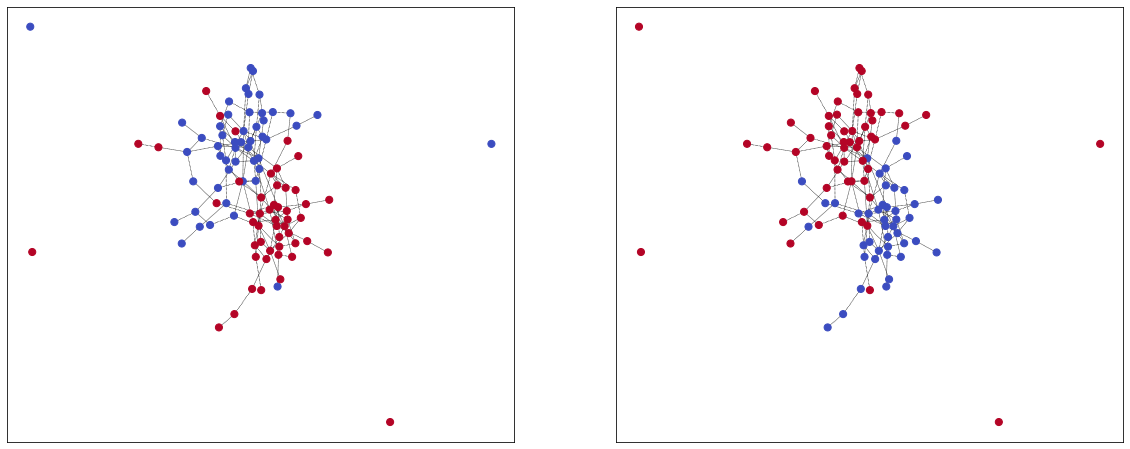

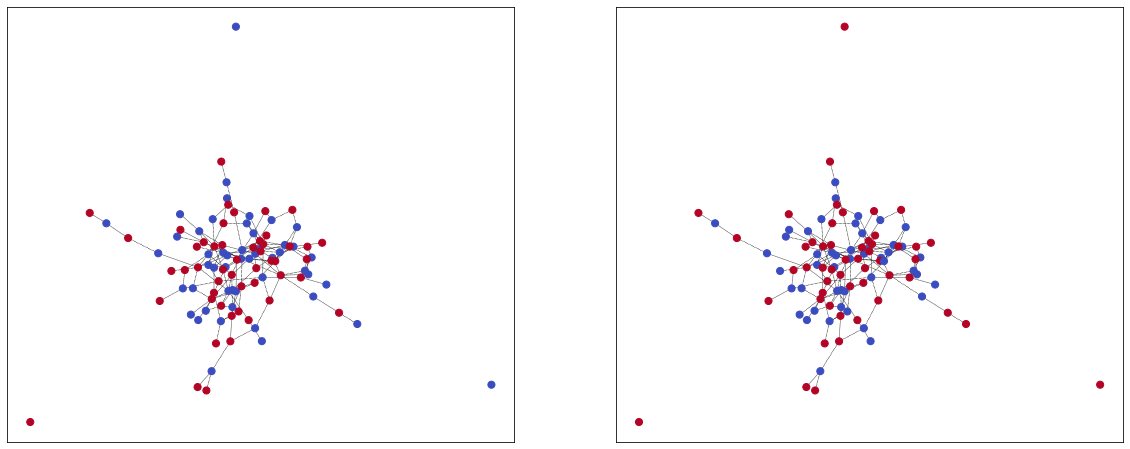

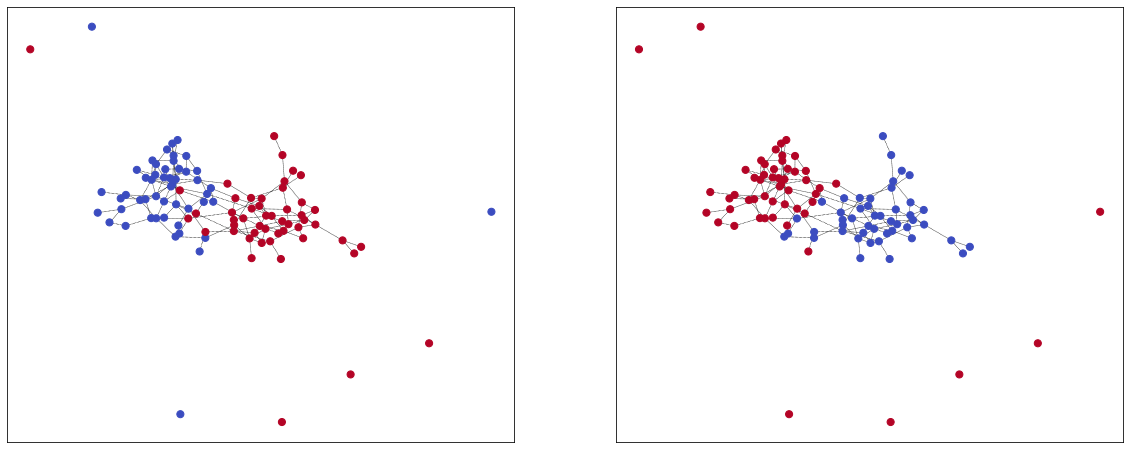

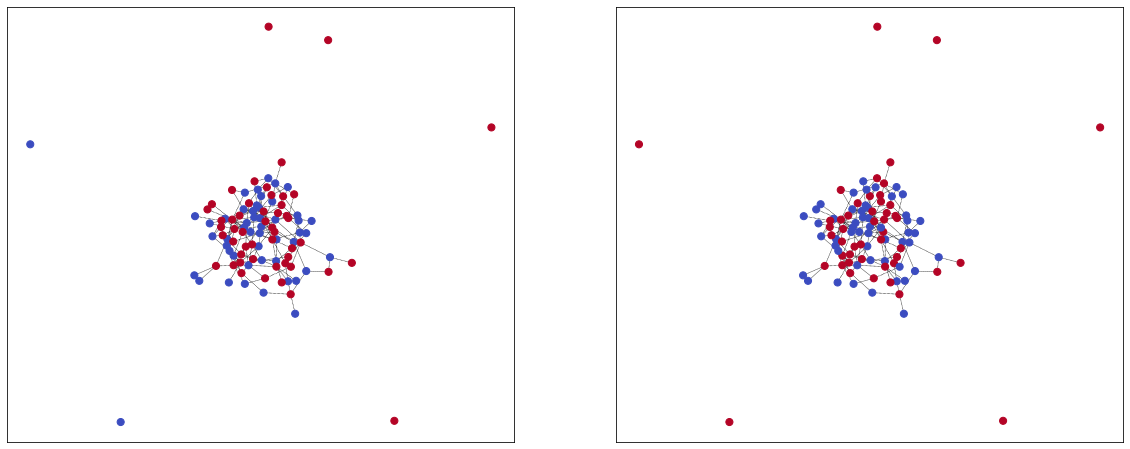

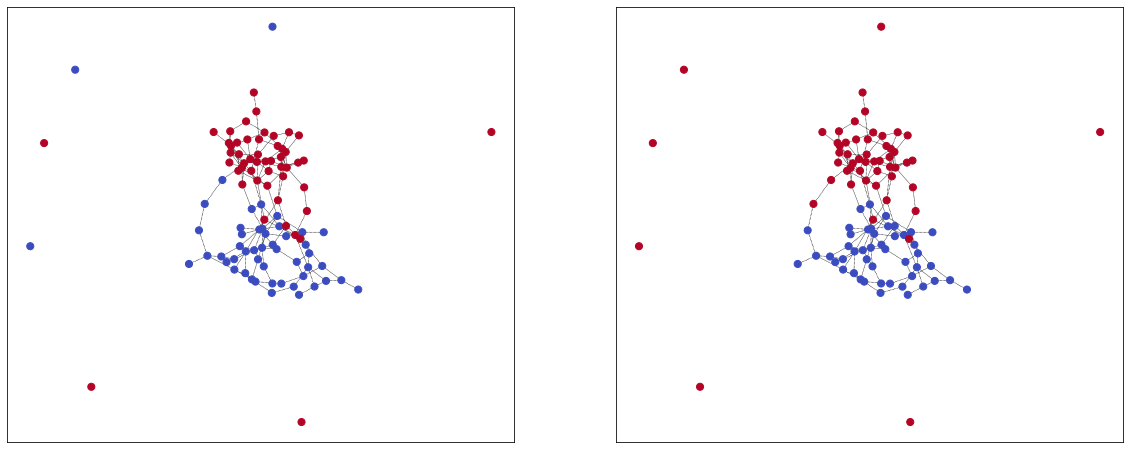

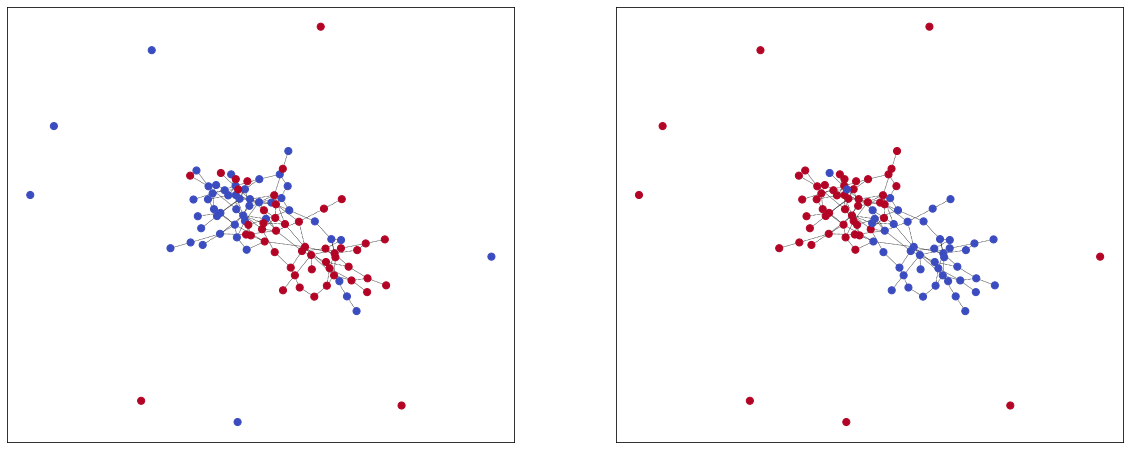

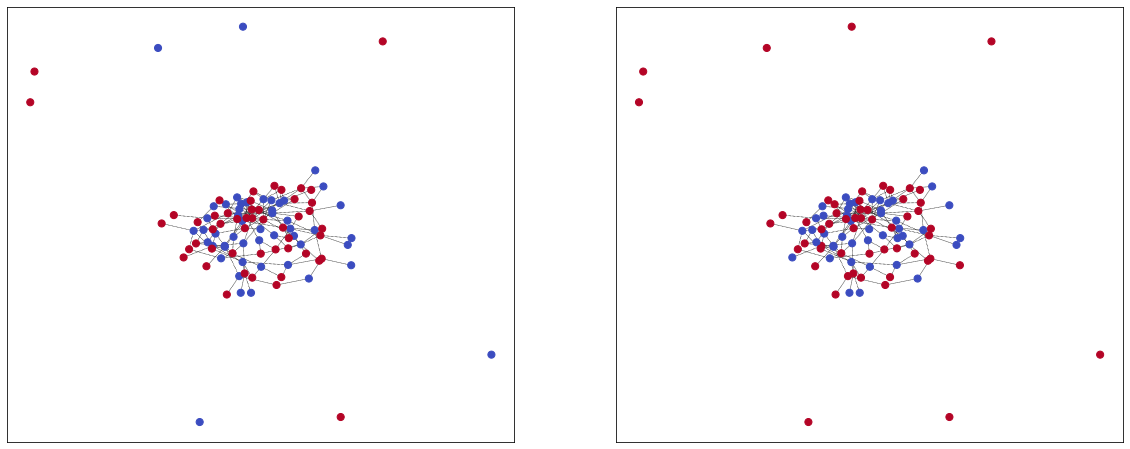

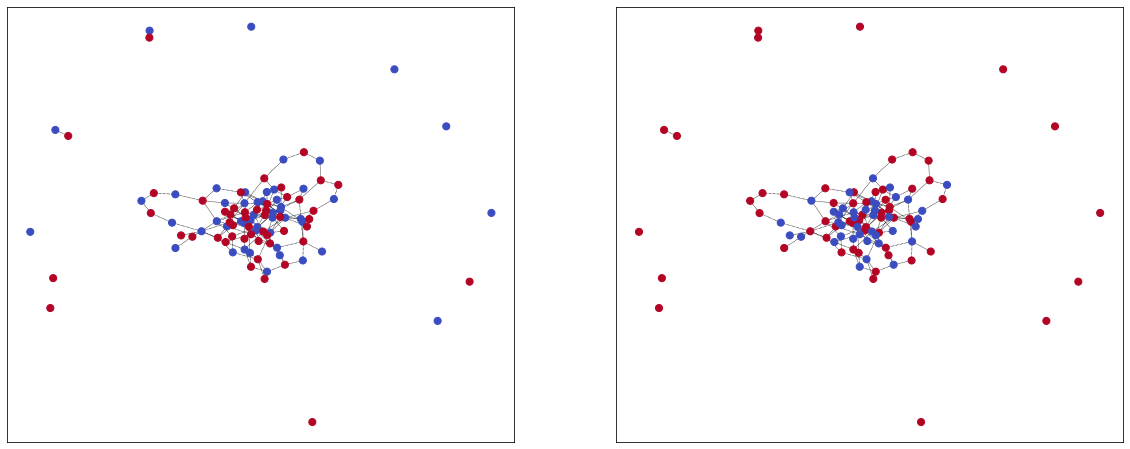

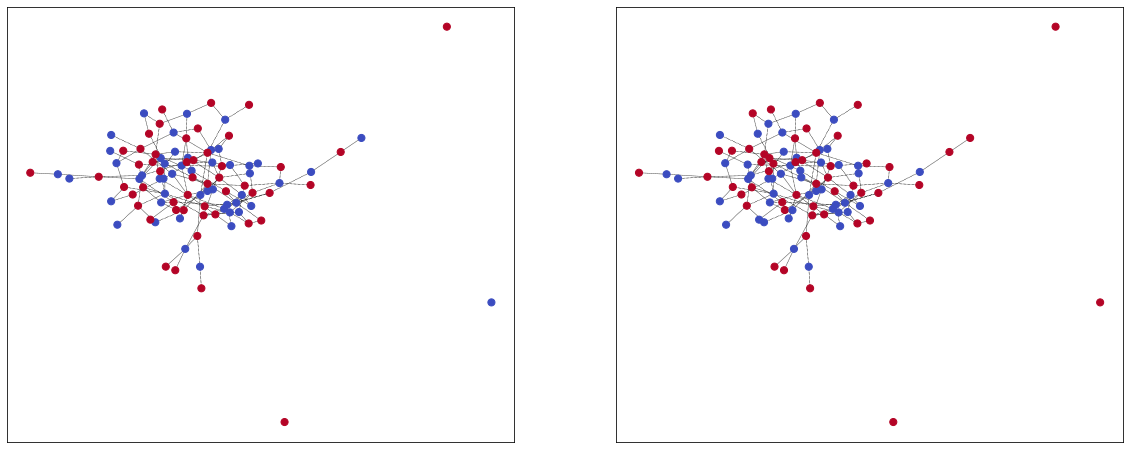

In [9]:
for G, LG, deg_G, deg_LG, pm_pd in training_dataset:
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    visualize(y_list[0].tolist(), G.to_networkx(), ax=axes[0])
    z = model(G, LG, deg_G, deg_LG, pm_pd)
    _, pred = th.max(z, 1)
    visualize(pred, G.to_networkx(), ax=axes[1])

# Sources
 * https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/6_line_graph.html
 * https://github.com/dmlc/dgl/tree/master/examples/pytorch/line_graph
 * https://arxiv.org/pdf/1705.08415.pdf